### Luis Arce, Lindy Castellaw, Jeremy Lagunas, Tim Keriazes

#### Sep 8, 2022

# NLP Github Classification Project - EndTheFed - Predicting #defi Repository Program Language From Readme Contents

#### Scenario

#### Project Description:
##### Utilizing the contents of readme files within repositories on github, we set out to build a predictive model that would allow us to determine the programming language of the repository/project based on the contents of the readme. Utilizing web scraping techniques, we built a dataset containing the name of the repository, the programming language utilized, and the contents of the readme. Through some basic cleaning and preparation we will explore the dataset, looking for patterns, and creating some visualizations that show the most common words in the readme, whether the length varies by programming language, unique words, and any other identifying features. We will utilize the TfidfVectorizer() to transform the contents of the readme into features that will be fed into our predictive classification models.


Project Planning/Outline:
1. Investigating the repository search #defi
2. Capture the urls/endpoints for all repos
3. Flatten endpoints/utilize acquire.py file to interact with github api to pull repo name, language, and readme contents
4. Data preparation/utilize prepare.py file to clean and prep data 
5. Exploration and Data Analysis/visualize dataset with analysis, word clouds, bigrams
6. Split the dataset
7. Model utilizing Tfidf vectorized readme contents
8. Evaluate Models
9. Test
10. Conclusions/Next Steps
 

#### Hypothesis
1. Contents of readme will be indicative of programming language used

### Target variable
#### language

### Exploration Key Findings/Results
Explore and visualize the natural language data that you have acquired. Here are some ideas for exploration:

#### 1. The most 10 most common words and the number of appearances in the readme were:
        
        contract    3914
        token       3460
        run         1740
        1           1722
        smart       1622
        ethereum    1530
        project     1530
        address     1503
        detail      1499
        install     1438
        

#### 2. Length of the readme did vary by programming language
#### 3. Javascript and Typescript utilized numeric characters/words much more so than other programming languages.
#### 4. Of the 1000 repositories that we pulled, the most common language breakdown is as follows:

        JavaScript		0.237624
        TypeScript		0.221782
        Solidity		0.165347
        Not Specified	0.127723
        Python		    0.058416
        Rust		    0.031683
        Go		        0.025743

#### 5. The top ten bigrams that appeared and their number of occurences across all languages were:

        (smart, contract)                           1348
        (git, clone)                                 759
        (detail, detailssummaryba)                   670
        (styledisplayinline, width13)                414
        (npm, install)                               350
        (srchttpsgitioj9co9, styledisplayinline)     342
        (codeimg, srchttpsgitioj9co9)                341
        (npm, run)                                   321
        (decimal, 18)                                315
        (chainid, 1)                                 309


# Best Model: 
### Refined Random Forest with max depth 6
    - We established baseline using the mode language of Javascript which appeared 0.27 of all occurrences. Our final model predictions on the test set are 0.71

### Key takeaways
    - Javascript was the most occurring language 
    - All models beat the baseline 
### Next Steps
    - Bring in other features like bigrams

In [1]:
from requests import get
from bs4 import BeautifulSoup
import os
import pandas as pd
import re
#import repo_github_api_acquire as aq
import requests
import time
import json
import nlp_acquire
import nlp_prepare
import prepare_repos

import unicodedata
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from wordcloud import WordCloud



from typing import Dict, List, Optional, Union, cast
from env import github_token, github_username


%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier

### CreateURLs, get URL endpoints, flatten endpoints, establish final values, write to CSV

In [ ]:
#creates Urls
nlp_acquire.create_urls()

In [ ]:
#makes endpoints
nlp_acquire.make_all_endpoints()

In [ ]:
#acquire endpoints and write csv to local
nlp_acquire.acquire_endpoints()

In [ ]:
#read in csv
final_values = pd.read_csv('endpoints.csv')  

In [ ]:
#flatten values of df, Put to list so it can be used in helper file repo_github_api_acquire 
final_values = nlp_acquire.flatten_endpoints()

In [ ]:
#establish variable of final values for helper function
REPOS = final_values.tolist()

In [ ]:
#utilize helper repo_github_api_acquire , input final_values.tolist() produces data.json on local machine
#allows the json file to be read in as data
with open('data.json', 'r') as f:
  data = json.load(f)

In [2]:
#read it into a df
df = pd.read_json('data.json')
df.head()

,repo,language,readme_contents
0,/OffcierCia/DeFi-Developer-Road-Map,None,# DeFi Developer Road Map\n\n**Here we collect...
1,/smartcontractkit/full-blockchain-solidity-cou...,None,<!-- [YouTube Video](https://www.youtube.com/w...
2,/rainbow-me/rainbow,TypeScript,![](https://pbs.twimg.com/profile_banners/1103...
3,/Bytom/bytom,Go,Bytom\n======\n\n[![Build Status](https://trav...
4,/DimensionDev/Maskbook,TypeScript,<!-- cspell:disable -->\n<!-- markdownlint-dis...


In [ ]:
df.shape

### Repos scraped, language and contents pulled, readme contents ready to be cleaned and prepped
- Lowercase everything
- Normalize unicode characters
- Replace anything that is not a letter, number, whitespace or a single quote.
- handle nulls
- tokenize
- remove stopwords
- lemmatize
- create new df with new features

In [5]:
df.isna().sum()

repo               0
language           0
readme_contents    0
dtype: int64

In [4]:
#handle the nulls
df["language"].fillna("Not Specified", inplace = True)

In [6]:
remaining_languages = df.language.value_counts()[df.language.value_counts() > 4].index
# Removing languages not kept
df = df[df.language.isin(remaining_languages)]

In [7]:
df['readme_contents'] = df.readme_contents.apply(prepare_repos.clean)

In [8]:
df.head()

,repo,language,readme_contents
0,/OffcierCia/DeFi-Developer-Road-Map,Not Specified,defi developer road map collect discus best de...
1,/smartcontractkit/full-blockchain-solidity-cou...,Not Specified,youtube video http www youtube com watch v m57...
2,/rainbow-me/rainbow,TypeScript,http pb twimg com profile banner 1103191459409...
3,/Bytom/bytom,Go,bytom build status http travis ci org bytom by...
4,/DimensionDev/Maskbook,TypeScript,cspell disable markdownlint disable inline htm...


### Exploration, Data Analysis, Visualization

In [ ]:
#percentage of languages

labels = pd.concat([df.language.value_counts(),
                    df.language.value_counts(normalize=True)], axis=1)
labels.columns = ['n', 'percent']
labels

In [ ]:
df.language.value_counts()

In [ ]:
scrape_repo_content = nlp_acquire.read_url_or_file_repo()
repo_df = nlp_prepare.make_dataframe(scrape_repo_content)


In [ ]:
repo_df = nlp_prepare.make_dataframe(scrape_repo_content)

In [ ]:
ADDITIONAL_STOPWORDS = []

def clean(text):
    'A simple function to cleanup text data'
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english') + ADDITIONAL_STOPWORDS
    text = (unicodedata.normalize('NFKD', text)
             .encode('ascii', 'ignore')
             .decode('utf-8', 'ignore')
             .lower())
    words = re.sub(r'[^\w\s]', '', text).split()
    return [wnl.lemmatize(word) for word in words if word not in stopwords]

In [ ]:
#breaking out the words of each of the most used languages
js_words = clean(' '.join(repo_df[repo_df.language == 'JavaScript'].readme_contents))
ts_words = clean(' '.join(repo_df[repo_df.language == 'TypeScript'].readme_contents))
notspec_words = clean(' '.join(repo_df[repo_df.language == 'Not Specified'].readme_contents))
solidity_words = clean(' '.join(repo_df[repo_df.language == 'Solidity'].readme_contents))
python_words= clean(' '.join(repo_df[repo_df.language == 'Python'].readme_contents))
rust_words= clean(' '.join(repo_df[repo_df.language == 'Rust'].readme_contents))
go_words= clean(' '.join(repo_df[repo_df.language == 'Go'].readme_contents))

all_words = clean(' '.join(repo_df.readme_contents))

In [ ]:
#frequency of the words
js_freq = pd.Series(js_words).value_counts()
ts_freq = pd.Series(ts_words).value_counts()
notspec_freq = pd.Series(notspec_words).value_counts()
solidity_freq = pd.Series(solidity_words).value_counts()
python_freq = pd.Series(python_words).value_counts()
rust_freq = pd.Series(rust_words).value_counts()
go_freq = pd.Series(go_words).value_counts()

all_freq = pd.Series(all_words).value_counts()

In [ ]:
#shows word counts
word_counts = (pd.concat([all_freq, js_freq, ts_freq, notspec_freq,solidity_freq, python_freq, rust_freq, go_freq], axis=1, sort=True)
                .set_axis(['all', 'js', 'ts','notspec','solidity','python','rust','go'], axis=1, inplace=False)
                .fillna(0)
                .apply(lambda s: s.astype(int)))

word_counts.head()

In [ ]:
#number of unique wordcounts
js_freq.nunique(),ts_freq.nunique(),notspec_freq.nunique(),solidity_freq.nunique(),python_freq.nunique(),rust_freq.nunique(),go_freq.nunique()

In [ ]:
word_counts.sort_values(by='all', ascending=False).head(10)

In [ ]:
#most used words
word_counts['all'].sort_values(ascending=False).head(10)

In [ ]:
# figure out the percentage of spam vs ham
(word_counts
 .assign(p_js=word_counts.js / word_counts['all'],
         p_ts=word_counts.ts / word_counts['all'],
         p_notspec=word_counts.notspec / word_counts['all'],
         p_solidity=word_counts.solidity / word_counts['all'],
         p_python=word_counts.python / word_counts['all'],
         p_rust=word_counts.rust / word_counts['all'],
         p_go=word_counts.go / word_counts['all'] 
        )
 .sort_values(by='all')
 [['p_js', 'p_ts','p_notspec','p_solidity','p_python','p_rust','p_rust','p_go']]
 .tail(25)
 .sort_values('p_js')
 .plot.barh(stacked=True))

plt.title('Proportion of Language for the 25 most common words')

In [ ]:
#top 20 bigrams
top_20_allwords_bigrams = (pd.Series(nltk.ngrams(all_words, 2))
                      .value_counts()
                      .head(20))

top_20_allwords_bigrams.head(10)

In [ ]:
#bigrams histogram
top_20_allwords_bigrams.sort_values(ascending=False).plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_allwords_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

In [ ]:
#Bigrams Word Cloud
data = {k[0] + ' ' + k[1]: v for k, v in top_20_allwords_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()

### Exploration Key Findings/Results
Explore and visualize the natural language data that you have acquired. Here are some ideas for exploration:

#### 1. The most 10 most common words and the number of appearances in the readme were:
        
        contract    3914
        token       3460
        run         1740
        1           1722
        smart       1622
        ethereum    1530
        project     1530
        address     1503
        detail      1499
        install     1438
        

#### 2. Length of the readme did vary by programming language
#### 3. Javascript and Typescript utilized numeric characters/words much more so than other programming languages.
#### 4. Of the 1000 repositories that we pulled, the most common language breakdown is as follows:

        JavaScript		0.237624
        TypeScript		0.221782
        Solidity		0.165347
        Not Specified	0.127723
        Python		    0.058416
        Rust		    0.031683
        Go		        0.025743

#### 5. The top ten bigrams that appeared and their number of occurences across all languages were:

        (smart, contract)                           1348
        (git, clone)                                 759
        (detail, detailssummaryba)                   670
        (styledisplayinline, width13)                414
        (npm, install)                               350
        (srchttpsgitioj9co9, styledisplayinline)     342
        (codeimg, srchttpsgitioj9co9)                341
        (npm, run)                                   321
        (decimal, 18)                                315
        (chainid, 1)                                 309


In [ ]:
repo_df.head()

### Modeling - Classification
baseline - 0.27
1. decision tree
2. random forest max depth 3
3. random forest max depth 6

In [12]:
#separating target from train
target=df['language']

In [13]:
target.head()

0    Not Specified
1    Not Specified
2       TypeScript
3               Go
4       TypeScript
Name: language, dtype: object

In [14]:
#separating target from train
df = df.drop(['language'], axis=1)

In [15]:
df.head()

,repo,readme_contents
0,/OffcierCia/DeFi-Developer-Road-Map,defi developer road map collect discus best de...
1,/smartcontractkit/full-blockchain-solidity-cou...,youtube video http www youtube com watch v m57...
2,/rainbow-me/rainbow,http pb twimg com profile banner 1103191459409...
3,/Bytom/bytom,bytom build status http travis ci org bytom by...
4,/DimensionDev/Maskbook,cspell disable markdownlint disable inline htm...


In [32]:
# split data and feature selection 
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df.readme_contents)
y = target

X_train, X_test_val, y_train, y_test_val = train_test_split(X, y,  test_size=.2)
X_validate, X_test, y_validate, y_test = train_test_split(X_test_val, y_test_val, test_size=.5)

In [33]:
# turn X_ into df with features 
X_train_df= pd.DataFrame(X_train.todense(), columns=tfidf.get_feature_names())
X_validate_df= pd.DataFrame(X_validate.todense(), columns=tfidf.get_feature_names())
X_test_df= pd.DataFrame(X_test.todense(), columns=tfidf.get_feature_names())

C:\Users\Timmy\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Timmy\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Timmy\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [34]:
# turn y_ into df
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)
y_test = pd.DataFrame(y_test)

In [35]:
# new df for predictions
predictions = pd.DataFrame({ 
    'actual': y_train.language
})
predictions['baseline'] = y_train[y_train['language'] == 'JavaScript'].shape[0] /y_train.shape[0]
predictions.head()

,actual,baseline
870,JavaScript,0.241071
890,JavaScript,0.241071
698,Solidity,0.241071
884,TypeScript,0.241071
479,Python,0.241071


Decision Tree

max depth 3

[Text(0.5, 0.875, 'yarn <= 0.015\ngini = 0.83\nsamples = 784\nvalue = [8, 11, 8, 20, 17, 3, 189, 9, 103, 45, 24, 5, 8\n137, 188, 9]\nclass = JavaScript'),
 Text(0.25, 0.625, 'python <= 0.022\ngini = 0.844\nsamples = 604\nvalue = [8, 11, 6, 19, 11, 2, 148, 9, 103, 45, 20, 4, 8\n114, 90, 6]\nclass = JavaScript'),
 Text(0.125, 0.375, 'npm <= 0.011\ngini = 0.833\nsamples = 566\nvalue = [8, 11, 6, 19, 11, 2, 148, 6, 100, 19, 19, 4, 8\n112, 87, 6]\nclass = JavaScript'),
 Text(0.0625, 0.125, 'gini = 0.846\nsamples = 409\nvalue = [8, 10, 5, 19, 10, 2, 81, 6, 96, 19, 16, 3, 7\n82, 43, 2]\nclass = Not Specified'),
 Text(0.1875, 0.125, 'gini = 0.701\nsamples = 157\nvalue = [0, 1, 1, 0, 1, 0, 67, 0, 4, 0, 3, 1, 1, 30\n44, 4]\nclass = JavaScript'),
 Text(0.375, 0.375, 'install <= 0.003\ngini = 0.51\nsamples = 38\nvalue = [0, 0, 0, 0, 0, 0, 0, 3, 3, 26, 1, 0, 0, 2\n3, 0]\nclass = Python'),
 Text(0.3125, 0.125, 'gini = 0.765\nsamples = 9\nvalue = [0, 0, 0, 0, 0, 0, 0, 3, 2, 1, 0, 0, 0, 1\n2, 0]\nclas

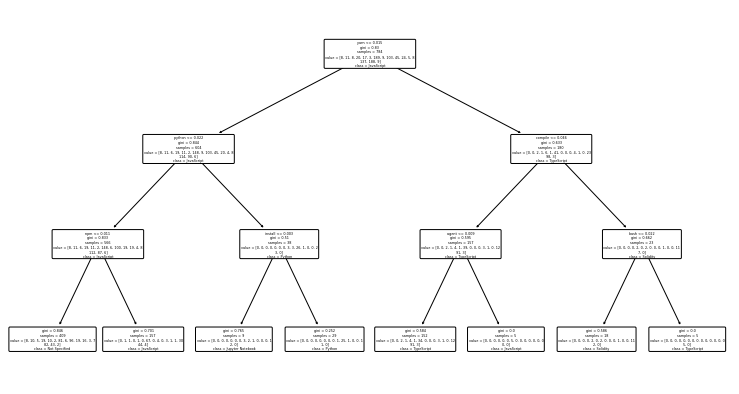

In [36]:
# fit model on train
clf = DecisionTreeClassifier(max_depth=3, random_state=123)
clf = clf.fit(X_train_df, y_train)

plt.figure(figsize=(13, 7))
plot_tree(clf, feature_names=X_train_df.columns, class_names=clf.classes_, rounded=True)

In [37]:
# put train predicitions into df
predictions['DT'] = clf.predict(X_train_df)
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
      .format(clf.score(X_train_df, y_train)))
predictions['DT'] = clf.score(X_train_df, y_train)

Accuracy of Decision Tree classifier on training set: 0.39


Random forest

max depth 3

In [38]:
rf = RandomForestClassifier(max_depth=3, min_samples_leaf=3, random_state=123)
rf.fit(X_train_df, y_train)
y_pred = rf.predict(X_train_df)
y_pred_proba = rf.predict_proba(X_train_df)
print('Accuracy of random forest classifier on training set: {:.2f}'
     .format(rf.score(X_train_df, y_train)))

predictions['RF'] = rf.score(X_train_df, y_train)

C:\Users\Timmy\AppData\Local\Temp\ipykernel_35196\2194313164.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train_df, y_train)


Accuracy of random forest classifier on training set: 0.43


Refined random forest

max depth 6

In [39]:
rf2 = RandomForestClassifier(max_depth=6, min_samples_leaf=3, random_state=123)
rf2.fit(X_train_df, y_train)

y_pred = rf2.predict(X_train_df)
y_pred_proba = rf2.predict_proba(X_train_df)
print('Accuracy of random forest classifier on training set: {:.2f}'
     .format(rf2.score(X_train_df, y_train)))

predictions['RF2'] = rf2.score(X_train_df, y_train)

predictions.head()

C:\Users\Timmy\AppData\Local\Temp\ipykernel_35196\4119635102.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf2.fit(X_train_df, y_train)


Accuracy of random forest classifier on training set: 0.48


,actual,baseline,DT,RF,RF2
870,JavaScript,0.241071,0.38648,0.433673,0.479592
890,JavaScript,0.241071,0.38648,0.433673,0.479592
698,Solidity,0.241071,0.38648,0.433673,0.479592
884,TypeScript,0.241071,0.38648,0.433673,0.479592
479,Python,0.241071,0.38648,0.433673,0.479592


# Testing on validate 

In [40]:
# new df for validate predictions
predictions_val = pd.DataFrame({ 
    'actual': y_validate.language
})
# add baseline to predictions tables 
predictions_val['baseline'] = y_train[y_train['language'] == 'JavaScript'].shape[0] /y_train.shape[0]

In [41]:
# decsion tree on validate

predictions_val['DT_val'] = clf.predict(X_validate_df)


print('Accuracy of Decision Tree classifier on training set: {:.2f}'
      .format(clf.score(X_validate_df, y_validate)))
predictions_val['DT_val'] = clf.score(X_validate_df, y_validate)

Accuracy of Decision Tree classifier on training set: 0.37


In [ ]:
# random forest on validate

rf2 = RandomForestClassifier(max_depth=6, min_samples_leaf=3, random_state=123)
rf2.fit(X_validate_df, y_validate)

y_pred = rf2.predict(X_validate_df)
y_pred_proba = rf2.predict_proba(X_validate_df)
print('Accuracy of random forest classifier on training set: {:.2f}'
     .format(rf2.score(X_validate_df, y_validate)))

predictions_val['RF2_val'] = rf2.score(X_validate_df, y_validate)

In [ ]:
predictions_val.head()

All of the models beat the baseline on the training and validate data, with the best performing one being refined random forest with a max depth of 6. That model will be used on the test set.

## Test on random forest

In [ ]:
# new df for test predictions
predictions_test = pd.DataFrame({ 
    'actual': y_test.language
})
predictions_test['baseline'] = y_train[y_train['language'] == 'JavaScript'].shape[0] /y_train.shape[0]

In [ ]:
# random forest on test

rf2 = RandomForestClassifier(max_depth=6, min_samples_leaf=3, random_state=123)
rf2.fit(X_test_df, y_test)

y_pred = rf2.predict(X_test_df)
y_pred_proba = rf2.predict_proba(X_test_df)
print('Accuracy of random forest classifier on training set: {:.2f}'
     .format(rf2.score(X_test_df, y_test)))

predictions_test['RF2_test'] = rf2.score(X_test_df, y_test)

In [ ]:
predictions_test.head()

## Conclusion 
We found that the most popular languages were JavaScript, TypeScript, Solidity, and Python. The most common words used across all READMEs were contract, token, and run. Our final model (Random Forest max depth of 6) performed with an accuracy of 68.4%. We didn’t expect there to be so many repos that aren’t labeled with a language and we didn’t expect so many random numeric strings to show up during our Feature Engineering.

If we had more time, we would investigate similarities across languages to see if we can determine the computing language used by unlabeled repositories.